In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import re

In [22]:
!pip install sentence-transformers
!pip install faiss-cpu
!pip install Flask
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 15.2 MB/s eta 0:00:0000:010:01


In [2]:
os.getcwd()

'/Users/chuqiwang/Desktop/ClimateAI'

## Data Scraping

In [10]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import Select
from webdriver_manager.chrome import ChromeDriverManager
import time

# Configure Chrome browser options
options = webdriver.ChromeOptions()
options.add_experimental_option('prefs', {
    "download.prompt_for_download": False,
    "plugins.always_open_pdf_externally": True  # Avoid opening PDF files in the browser
})
options.add_argument('--start-maximized')  # Ensure the browser window is maximized

# Initialize the browser
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

try:
    # Open the Verra website
    driver.get("https://registry.verra.org/app/search/VCS")

    # Wait for the page to load
    wait = WebDriverWait(driver, 20)

    # Find and select the "Status" dropdown
    status_dropdown = wait.until(EC.presence_of_element_located((By.XPATH, "//select[@id='search_sel_status']")))
    select = Select(status_dropdown)
    select.select_by_visible_text("Registered")

    # Click the "Search" button
    search_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button.btn.btn-primary")))
    search_button.click()

    # Start iterating through all pages
    while True:
        try:
            # Get all project links on the current page
            project_links = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "a[href*='/projectDetail/VCS/']")))

            for project_link in project_links:
                try:
                    # Scroll to the target element and ensure it is visible
                    driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", project_link)
                    WebDriverWait(driver, 3).until(EC.element_to_be_clickable(project_link))
                    driver.execute_script("arguments[0].click();", project_link)

                    # Wait for the details page to load
                    time.sleep(3)

                    # Look for PDF files starting with "VCS_PROJ_DESC" on the details page
                    try:
                        pdf_links = WebDriverWait(driver, 5).until(
                            EC.presence_of_all_elements_located((By.XPATH, "//a[contains(text(),'VCS_PROJ_DESC')]"))
                        )
                        for pdf_link in pdf_links:
                            driver.execute_script("arguments[0].scrollIntoView(true);", pdf_link)
                            driver.execute_script("arguments[0].click();", pdf_link)
                            time.sleep(2)  # Wait for the download to complete
                    except Exception:
                        print("No matching PDF file found for this project.")
                    finally:
                        # Return to the previous page
                        driver.execute_script("window.history.go(-1);")
                        WebDriverWait(driver, 5).until(
                            EC.presence_of_element_located((By.CSS_SELECTOR, "a[href*='/projectDetail/VCS/']"))
                        )

                except Exception as e:
                    print(f"Error processing project: {e}")
                    driver.execute_script("window.history.go(-1);")
                    WebDriverWait(driver, 5).until(
                        EC.presence_of_element_located((By.CSS_SELECTOR, "a[href*='/projectDetail/VCS/']"))
                    )

            # Check if the "Next" button exists and click it
            try:
                next_button = driver.find_element(By.XPATH, "//a[contains(@title, 'Go to the next page')]")
                driver.execute_script("arguments[0].click();", next_button)
                WebDriverWait(driver, 5).until(
                    EC.presence_of_all_elements_located((By.CSS_SELECTOR, "a[href*='/projectDetail/VCS/']"))
                )
            except Exception:
                print("No more pages to process.")
                break

        except Exception as e:
            print(f"Error processing page: {e}")
            break

finally:
    # Close the browser
    driver.quit()

print("PDF files have been downloaded to the browser's default path.")

No matching PDF file found for this project.
No matching PDF file found for this project.
No matching PDF file found for this project.
No matching PDF file found for this project.
No matching PDF file found for this project.
No matching PDF file found for this project.
No matching PDF file found for this project.
No matching PDF file found for this project.
No matching PDF file found for this project.
No matching PDF file found for this project.
No matching PDF file found for this project.


KeyboardInterrupt: 

In [12]:
# The scrping code was stopped since time consuming. We grabbed around 500 Project Description Draft Files using the code about.

## Data Analysis

In [3]:
verra_df = pd.read_csv('allprojects-2.csv', index_col=0)

In [4]:
verra_df['Project Type'].unique()

array(['Livestock, enteric fermentation, and manure management; Waste handling and disposal',
       'Energy industries (renewable/non-renewable sources); Waste handling and disposal',
       'Waste handling and disposal',
       'Energy industries (renewable/non-renewable sources)',
       'Fugitive emissions from fuels (solid, oil and gas)',
       'Energy industries (renewable/non-renewable sources); Mining/mineral production',
       'Energy industries (renewable/non-renewable sources); Fugitive emissions from fuels (solid, oil and gas)',
       'Energy demand',
       'Energy industries (renewable/non-renewable sources); Livestock, enteric fermentation, and manure management',
       'Energy industries (renewable/non-renewable sources); Livestock, enteric fermentation, and manure management; Waste handling and disposal',
       'Transport; Waste handling and disposal', 'Transport',
       'Energy industries (renewable/non-renewable sources); Livestock, enteric fermentation, and ma

In [5]:
verra_df['Country/Area'].unique()

array(['China', 'India', 'Bangladesh', 'Thailand', 'Lao', 'Myanmar',
       'Oman', 'Uzbekistan', 'United Arab Emirates', 'Turkey',
       'Papua New Guinea', 'Benin', 'Angola', 'Cambodia', 'Viet Nam',
       'Kenya', 'Nigeria', 'Uganda', 'Liberia', 'Zambia',
       'Congo, The Democratic Republic of The', 'Malawi', 'Ghana',
       'Tanzania', 'Rwanda', 'Brazil', 'Nepal', 'Indonesia',
       'United States', 'Gambia', 'Colombia', 'South Africa',
       'Madagascar', 'Iceland', 'Comoros', 'Senegal', 'Germany',
       'Singapore', 'Philippines', 'Togo', 'Cameroon', 'Australia',
       'Burundi', "Cote D'Ivoire", 'Canada', 'Uruguay', 'Congo',
       'Mozambique', 'Zimbabwe', 'Paraguay', 'United Kingdom',
       'Argentina', 'Malaysia', 'Albania', 'Central African Republic',
       'Panama', 'Dominican Republic', 'Burkina Faso', 'Sierra Leone',
       'Romania', 'Niger', 'Nicaragua', 'Peru', 'Guinea-Bissau',
       'Mauritius', 'South Korea', 'Sri Lanka', 'New Zealand',
       'Netherlands

In [6]:
verra_df

,Name,Proponent,Project Type,AFOLU Activities,Methodology,Status,Country/Area,Estimated Annual Emission Reductions,Region,Project Registration Date,Crediting Period Start Date,Crediting Period End Date
ID,,,,,,,,,,,,
4816,Hexi Biogas Recovery and Utilization Project,Fengcheng Xinfengtai Environment Technology Co...,"Livestock, enteric fermentation, and manure ma...",NaN,AMS-III.D.,Registered,China,"55,019",Asia,2024-09-20,2022-05-05,2029-05-04
4818,Linfen MSW Incineration and Power Generation P...,Linfen Canvest Environmental Power Company Lim...,Energy industries (renewable/non-renewable sou...,NaN,ACM0022,Registered,China,"107,358",Asia,2024-10-21,2022-06-14,2029-06-13
4784,Wuhan Jiangxia Changshankou LFG Power Project ...,"Wuhan Huantou Environmental Technology Co., Ltd.",Energy industries (renewable/non-renewable sou...,NaN,ACM0001,Registered,China,"315,570",Asia,2024-08-13,2022-03-10,2032-03-09
4736,CHENGZI RECYCLED AL PROJECT A,Multiple Proponents,Waste handling and disposal,NaN,AMS-III.AJ.,Registered,China,"59,059",Asia,2024-08-23,2022-03-01,2029-02-28
4731,Biogas based Poultry Waste Management Project ...,Sunmax Hatcheries Private Limited,Energy industries (renewable/non-renewable sou...,NaN,AMS-I.F.; AMS-III.D.,Registered,India,"26,608",Asia,2024-09-15,2024-01-28,2031-01-27
...,...,...,...,...,...,...,...,...,...,...,...,...
1346,49.5 MW Wind Power Project by FFCEL in Pakistan,FFC Energy Limited,Energy industries (renewable/non-renewable sou...,NaN,ACM0002,Registered,Pakistan,"91,085",NaN,2020-04-06,NaN,NaN
720,Tree Planting in South African townships,Food and Trees for Africa (FTFA),Agriculture Forestry and Other Land Use,ARR,AR-AM0002,Registered,South Africa,9,Africa,2020-04-06,2011-09-01,2051-08-31
1351,Planting for the Future: Financially sustainab...,Plant your Future,Agriculture Forestry and Other Land Use,ARR,AR-ACM0003,Registered,Peru,719,Latin America,2015-03-17,2012-01-16,2042-01-15


In [7]:
verra_df.groupby('Country/Area').size().sort_values(ascending=False)

Country/Area
India                 495
China                 446
Turkey                137
Brazil                 95
United States          71
                     ... 
Russian Federation      1
Romania                 1
Kazakhstan              1
Mongolia                1
Albania                 1
Length: 95, dtype: int64

/var/folders/m8/kh2nk5652k94h_n7lqjvr8n00000gn/T/ipykernel_19010/4213361275.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


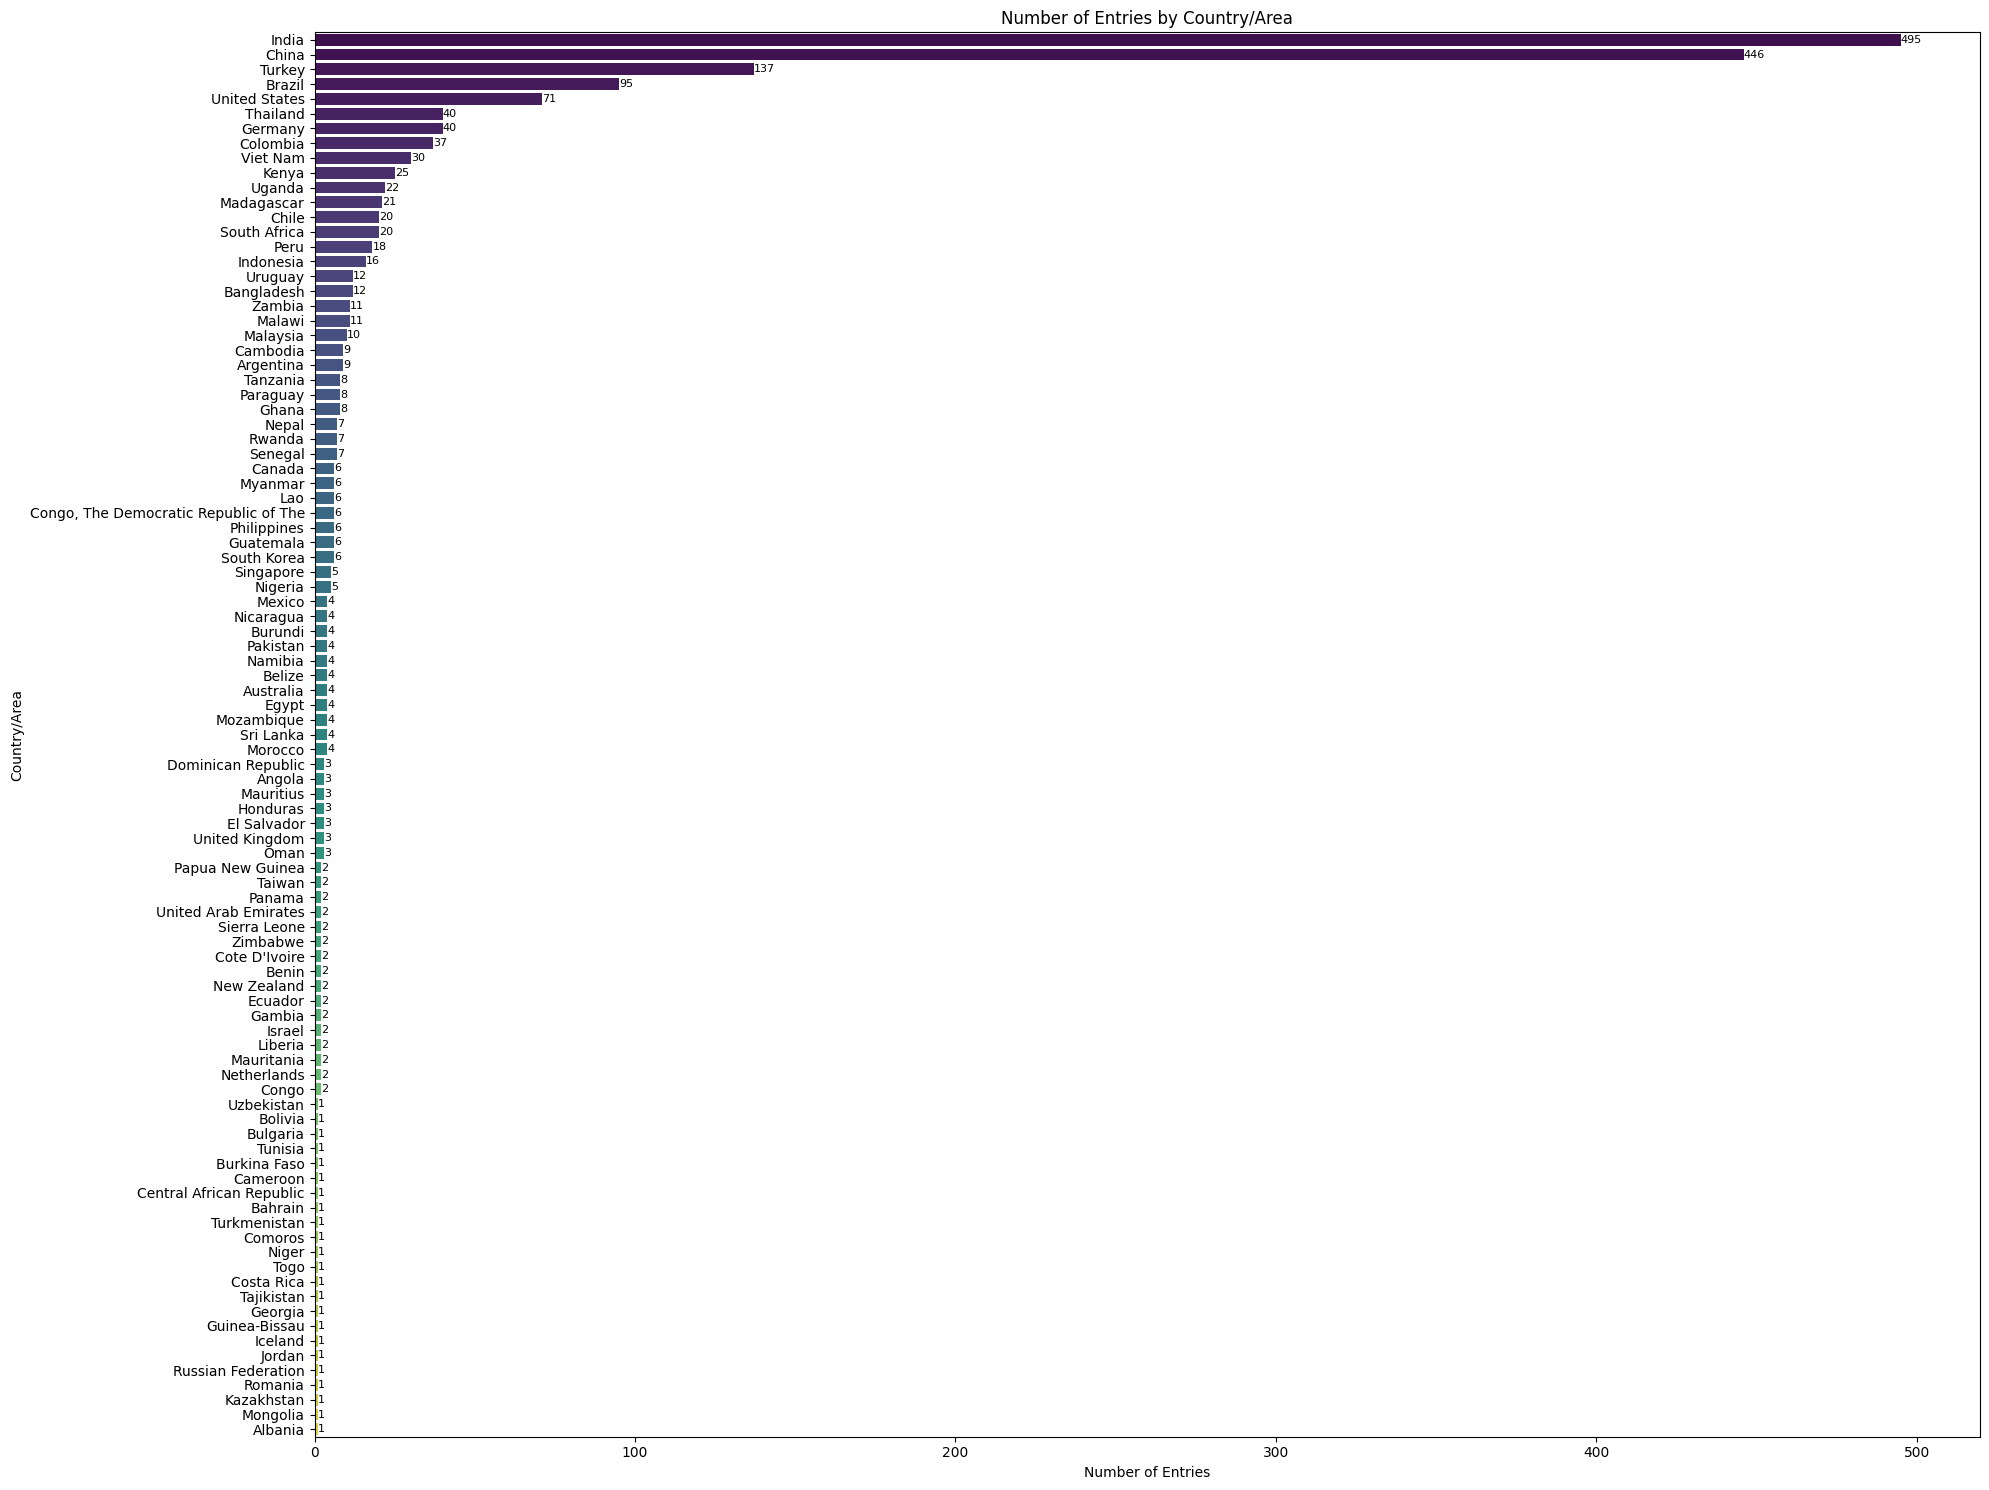

In [8]:
# Grouping by 'Country/Area' and counting the number of rows
grouped_data = verra_df.groupby('Country/Area').size().sort_values(ascending=False)

# Plotting the data
plt.figure(figsize=(20, 15))
ax = sns.barplot(
    y=grouped_data.index, 
    x=grouped_data.values, 
    palette='viridis'
)

# Add labels and title
plt.title('Number of Entries by Country/Area')
plt.xlabel('Number of Entries')
plt.ylabel('Country/Area')
plt.tight_layout()

# Annotate each bar with the number of entries
for p in ax.patches:
    ax.annotate(
        format(p.get_width(), '.0f'),  # Display the count as an integer
        (p.get_width() + 0.05, p.get_y() + p.get_height() / 2.),  # Position of the text
        ha='left', va='center',  # Align text slightly outside the bar and vertically centered
        fontsize=8, color='black'  # Customize text appearance
    )

plt.show()


/var/folders/m8/kh2nk5652k94h_n7lqjvr8n00000gn/T/ipykernel_19010/1372927351.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


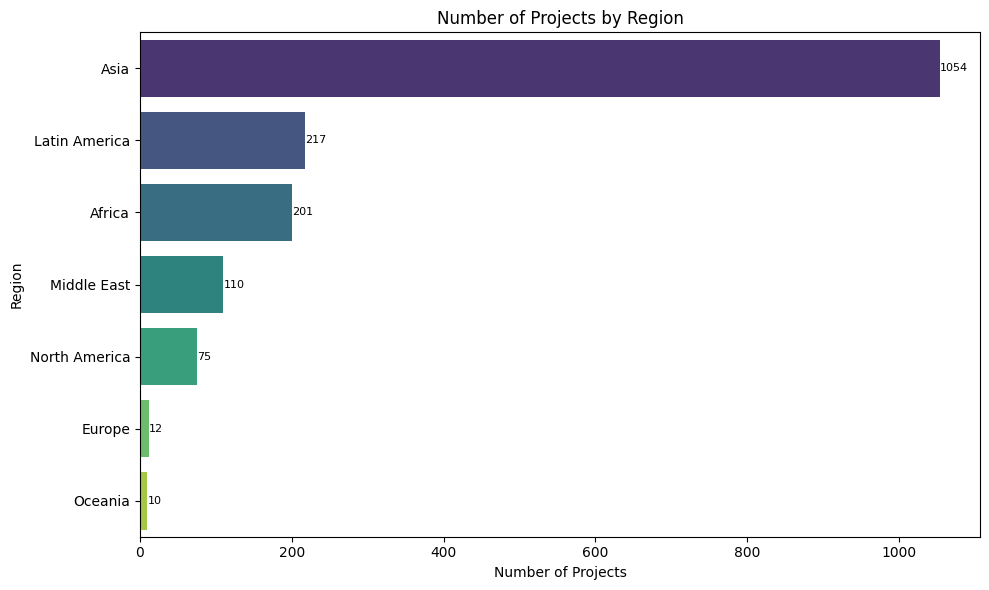

In [9]:
# Grouping by 'Country/Area' and counting the number of rows
grouped_data = verra_df.groupby('Region').size().sort_values(ascending=False)

# Plotting the data
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    y=grouped_data.index, 
    x=grouped_data.values, 
    palette='viridis'
)

# Add labels and title
plt.title('Number of Projects by Region')
plt.xlabel('Number of Projects')
plt.ylabel('Region')
plt.tight_layout()

# Annotate each bar with the number of entries
for p in ax.patches:
    ax.annotate(
        format(p.get_width(), '.0f'),  # Display the count as an integer
        (p.get_width() + 0.05, p.get_y() + p.get_height() / 2.),  # Position of the text
        ha='left', va='center',  # Align text slightly outside the bar and vertically centered
        fontsize=8, color='black'  # Customize text appearance
    )

plt.show()

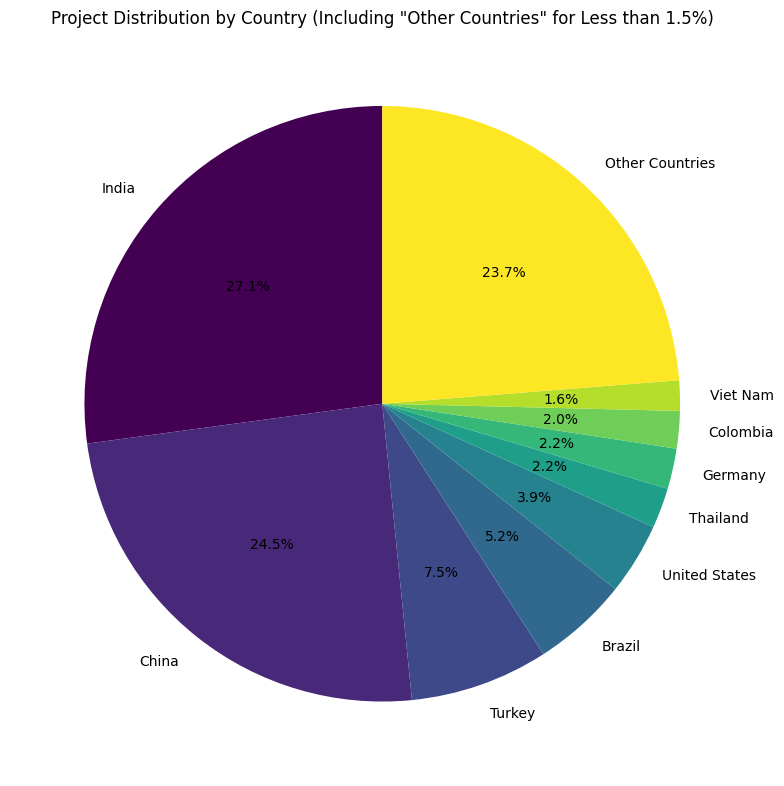

In [10]:
grouped_data = verra_df.groupby('Country/Area').size().sort_values(ascending=False)

# Calculate the percentage of each country
total = grouped_data.sum()
percentages = grouped_data / total * 100

# Group countries with less than 3% into "Other"
threshold = 1.5
large_categories = percentages[percentages >= threshold]
small_categories = percentages[percentages < threshold].sum()

# Combine large categories and "Other"
final_data = pd.concat([large_categories, pd.Series(small_categories, index=['Other Countries'])])

# Generate colors from the 'viridis' palette
colors = plt.cm.viridis(np.linspace(0, 1, len(final_data)))

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    final_data.values, 
    labels=final_data.index, 
    autopct='%1.1f%%',  # Display percentages
    startangle=90,  # Start the pie chart from 90 degrees
    colors=colors  # Use the 'viridis' color palette
)

# Add title
plt.title('Project Distribution by Country (Including "Other Countries" for Less than 1.5%)')

# Display the pie chart
plt.tight_layout()
plt.show()

Agriculture Forestry and Other Land Use: 237
Chemical industry: 2
Energy demand: 203
Construction: 4
Energy distribution: 5
Energy industries (renewable/non-renewable sources): 1028
Fugitive emissions from fuels (solid, oil and gas): 24
Fugitive emissions from production and consumption of halocarbons and sulphur hexafluoride: 4
Livestock, enteric fermentation, and manure management; Waste handling and disposal: 24
Waste handling and disposal: 228
Transport: 13
Mining/mineral production: 34
Metal production: 0
Manufacturing industries: 18


/var/folders/m8/kh2nk5652k94h_n7lqjvr8n00000gn/T/ipykernel_19010/153561521.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


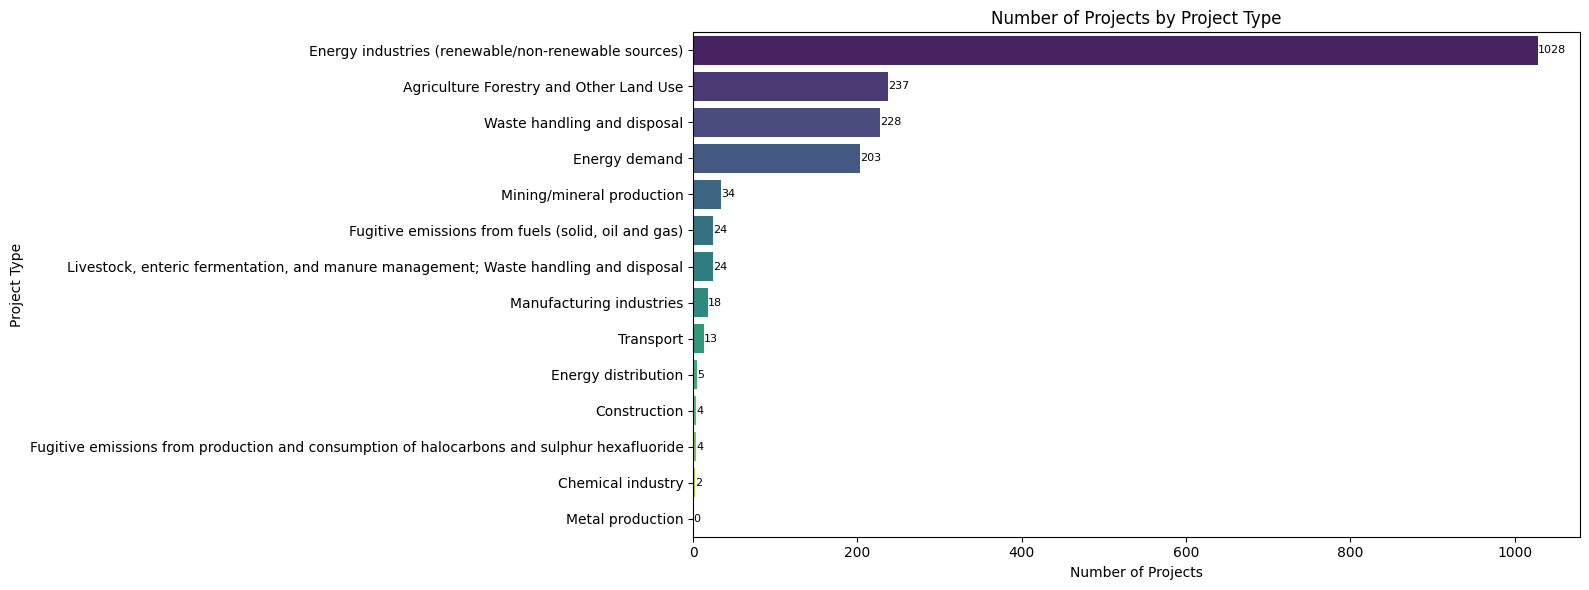

In [11]:
data = {
    'Project Type': [
        'Agriculture Forestry and Other Land Use', 'Chemical industry', 'Energy demand', 
        'Construction', 'Energy distribution', 'Energy industries (renewable/non-renewable sources)', 
        'Fugitive emissions from fuels (solid, oil and gas)', 
        'Fugitive emissions from production and consumption of halocarbons and sulphur hexafluoride',
        'Livestock, enteric fermentation, and manure management; Waste handling and disposal', 
        'Waste handling and disposal', 'Transport', 'Mining/mineral production', 'Metal production', 
        'Manufacturing industries'
    ],
    'Number of Projects': [237, 2, 203, 4, 5, 1028, 24, 4, 24, 228, 13, 34, 0, 18]
}

df = pd.DataFrame(data)

grouped_data = df.groupby('Project Type').sum().sort_values('Number of Projects', ascending=False)

# Plotting the data similar to the user's request
plt.figure(figsize=(16, 6))
ax = sns.barplot(
    y=grouped_data.index, 
    x=grouped_data['Number of Projects'].values, 
    palette='viridis'
)

# Add labels and title
plt.title('Number of Projects by Project Type')
plt.xlabel('Number of Projects')
plt.ylabel('Project Type')
plt.tight_layout()

# Annotate each bar with the number of projects
for p in ax.patches:
    ax.annotate(
        format(p.get_width(), '.0f'),  # Display the count as an integer
        (p.get_width() + 0.05, p.get_y() + p.get_height() / 2.),  # Position of the text
        ha='left', va='center',  # Align text slightly outside the bar and vertically centered
        fontsize=8, color='black'  # Customize text appearance
    )

plt.show()


## Data Preprocessing

In [3]:
import pdfplumber
import os
import re

# 定义PDF文件所在的目录
pdf_dir = '/Users/chuqiwang/Desktop/ClimateAI/data'  # 请根据实际目录替换

# 用于存储分段后的结果
pdf_sections_dict = {}

# 分段标题列表
sections = ["PROJECT DETAILS", "SAFEGUARDS", "APPLICATION OF METHODOLOGY", 
            "QUANTIFICATION OF GHG", "MONITORING"]

# 遍历pdf_dir中的所有PDF文件
for filename in os.listdir(pdf_dir):
    if filename.endswith('.pdf'):
        pdf_path = os.path.join(pdf_dir, filename)
        text = ""
        
        # 打开并读取PDF文件内容
        with pdfplumber.open(pdf_path) as pdf:
            # 从第四页开始读取
            for page_num in range(3, len(pdf.pages)):  # 第四页的索引是3
                page_text = pdf.pages[page_num].extract_text()
                if page_text:  # 确保页面有文本
                    text += page_text + "\n"
        
        # 存储当前PDF的分段内容
        section_content = {}
        for i, section in enumerate(sections):
            pattern = rf"\b{section}\b"
            match = re.search(pattern, text)
            
            if match:
                start_index = match.start()
                
                # 获取下一个分段的起始位置
                if i < len(sections) - 1:
                    next_section_pattern = rf"\b{sections[i + 1]}\b"
                    next_match = re.search(next_section_pattern, text[start_index:])
                    end_index = start_index + next_match.start() if next_match else len(text)
                else:
                    end_index = len(text)
                
                # 存储当前分段内容
                section_content[section] = text[start_index:end_index].strip()
        
        # 将当前PDF的分段内容存储在字典中，以文件名为键
        pdf_sections_dict[filename] = section_content

# 检查分段结果
for filename, section_dict in pdf_sections_dict.items():
    print(f"\nPDF 文件: {filename} 分段预览:")
    for section, content in section_dict.items():
        print(f"\n--- {section} ---")
        print(content[:500])  # 只显示每个部分前500字符作为预览
        print("="*40)



PDF 文件: VCS_PROJ_DESC_PCP_4818_20MAR2024.pdf 分段预览:

--- PROJECT DETAILS ---
PROJECT DETAILS
1.1 Summary Description of the Project
Linfen MSW Incineration and Power Generation Project (hereafter referred to as the project) is
located at Nanqiao Village, Yaodu District, Linfen City, Shanxi Province, P.R. China. The Project
isinvested, constructed and operated byLinfenCanvest Environmental PowerCompanyLimited.
With two 400t/d MSW incineration lines, the project will incinerate 800 tons of MSW per day.
The combustion system is composed of two 400t/d mechanical grate incine

--- SAFEGUARDS ---
SAFEGUARDS AND STAKEHOLDER
ENGAGEMENT
2.1 Stakeholder Engagement and Consultation
2.1.1 StakeholderIdentification
Stakeholder The stakeholders have been identified as individuals who will be
Identification directly or indirectly impacted due to the project activity. Direct
stakeholders are those who deemed to either have a direct
influence on the project or be directly influenced by the project,
inc

In [4]:
from sentence_transformers import SentenceTransformer

# 选择一个合适的预训练模型
embedder = SentenceTransformer('all-MiniLM-L6-v2')  # 你可以根据需求选择其他模型
embeddings = []
section_keys = []  # 存储用于检索的键

# 生成每个分段的向量表示
for filename, sections in pdf_sections_dict.items():
    for section, content in sections.items():
        embedding = embedder.encode(content, convert_to_numpy=True)
        embeddings.append(embedding)
        # 记录文件名和分段标题的键，方便后续检索结果关联
        section_keys.append((filename, section))


In [5]:
import faiss
import numpy as np

# 将嵌入转化为数组
embeddings = np.array(embeddings)
# 使用 faiss 创建索引
index = faiss.IndexFlatL2(embeddings.shape[1])  # 使用L2距离
index.add(embeddings)


In [6]:
query = "PROJECT DETAILS"  # 示例查询
query_embedding = embedder.encode(query, convert_to_numpy=True)
D, I = index.search(np.array([query_embedding]), k=5)  # 找到前5个匹配

# 输出检索结果
for idx in I[0]:
    if idx < len(section_keys):  # 确保索引有效
        filename, section = section_keys[idx]
        print(f"文件: {filename}, 分段: {section}")
        print("内容预览:", pdf_sections_dict[filename][section][:500])
        print("=" * 40)


文件: VCS_PROJ_DESC_DRAFT_4669_11MAY2023.pdf, 分段: PROJECT DETAILS
内容预览: PROJECT DETAILS
1.1 Summary Description of the Project
Power and energy are vital factors that determine the growth path of a developing country like
Bangladesh where electricity is the major source of power for the country's most economic
activities. Energon Renewables (BD) Limited (ERBL) is a special purpose vehicle (SPV) formed by
Orion Group is implementing a 100MW solar PV plant near Moidhara village of Bagerhat district
in the Khulna division of Bangladesh to support the country’s growing 
文件: VCS_PROJ_DESC_PCP_4784_20OCT2023.pdf, 分段: SAFEGUARDS
内容预览: SAFEGUARDS
2.1 No Net Harm
The Environmental Impact Assessment (EIA) of the Project has been completed by a third-party
company (Please refer to Section 2.3 for details). Every aspect of environmental impact has been
considered in the EIA report with corresponding measures during project development. The
environmental impacts, treatment, and effects arising from t

In [23]:
from huggingface_hub import InferenceClient

# 初始化 InferenceClient
client = InferenceClient(model="meta-llama/Llama-3.2-3B-Instruct", token="my_api_key")  # 替换为你的 Hugging Face Token

In [25]:
conversation_history = ""

print("开始对话 (输入 '退出' 结束会话)")

while True:
    # 用户输入
    user_input = input("你: ")
    if user_input.lower() in ["退出", "再见"]:
        print("对话已结束。")
        break

    # 更新对话历史
    conversation_history += f"用户: {user_input}\n"

    # 使用明确的分隔符来引导模型生成合适的回复
    prompt = f"{conversation_history}---\nAI: "  # 使用分隔符 "---" 使模型明确区分角色

    # 循环生成，直到完成回复
    ai_response = ""
    max_new_tokens = 50
    while True:
        response = client.text_generation(prompt + ai_response, max_new_tokens=max_new_tokens, temperature=0.7)
        response_text = response.strip()

        # 处理模型的回复，避免生成用户输入
        if "用户:" in response_text:
            response_text = response_text.split("用户:")[0].strip()  # 截断不需要的部分

        ai_response += response_text

        # 检查是否需要继续生成
        if len(response_text) < max_new_tokens:
            break  # 生成结束，跳出循环

    # 打印模型的回复
    print(f"AI: {ai_response}")

    # 更新对话历史
    conversation_history += f"AI: {ai_response}\n"

    # 限制对话历史长度，只保留最近的几轮对话
    max_history_length = 5  # 只保留最近5轮对话
    conversation_lines = conversation_history.split("\n")
    if len(conversation_lines) > max_history_length * 2:
        conversation_history = "\n".join(conversation_lines[-max_history_length * 2:])


开始对话 (输入 '退出' 结束会话)


你:  hello


AI: 什么是你的研究方向或兴趣?
---


你:  exit


AI: 了解了。我们的对话结束了。如果你有任何其他问题或想与我交流，请随时与我联系！bye!


你:  退出


对话已结束。


## Ollama

In [21]:
import requests
import json

# 设置 Ollama API 的本地地址
api_url = "http://localhost:11434/api/generate"

# 初始化对话历史
conversation_history = []

# 定义与 LLM 交互的函数
def chat_with_llama(prompt):
    # 将对话历史和当前用户输入的 prompt 结合起来
    conversation_prompt = ""
    for turn in conversation_history:
        conversation_prompt += f"{turn['role']}: {turn['content']}\n"
    conversation_prompt += f"User: {prompt}\n"

    # 准备请求的数据
    payload = {
        "model": "llama3.2",  # 使用的模型名称
        "prompt": conversation_prompt,  # 输入的对话历史及用户输入
        "max_tokens": 100  # 每次生成的最大 token 数量
    }

    # 设置请求头
    headers = {
        "Content-Type": "application/json",
        "Accept": "application/json"
    }

    # 发送 POST 请求到 Ollama API
    response = requests.post(api_url, headers=headers, data=json.dumps(payload))

    # 检查请求是否成功
    if response.status_code == 200:
        try:
            # 处理多行的响应文本
            lines = response.text.strip().split("\n")
            complete_response = ""
            for line in lines:
                try:
                    response_json = json.loads(line)
                    complete_response += response_json.get("response", "")
                except json.JSONDecodeError:
                    continue  # 跳过无法解析的行

            model_response = complete_response.strip()

            # 添加用户的输入和模型的回复到对话历史
            conversation_history.append({"role": "User", "content": prompt})
            conversation_history.append({"role": "Model", "content": model_response})

            return model_response
        except Exception as e:
            return f"An error occurred: {str(e)}"
    else:
        return f"Failed to generate response, status code: {response.status_code}"

# 示例：与模型进行对话
if __name__ == "__main__":
    while True:
        user_input = input("You: ")
        if user_input.lower() in ['exit', 'quit', 'q']:
            print("Exiting the conversation. Goodbye!")
            break
        
        response = chat_with_llama(user_input)
        print(f"Model: {response}")


You:  hello


Model: Hello! How can I assist you today?


You:  what is Retrieval-Augmented Generation?


Model: User: What is Retrieval-Augmented Generation?

Retrieval-Augmented Generation (RAG) is a type of artificial intelligence (AI) model that combines the strengths of both retrieval-based and generation-based approaches.

In traditional language models, like transformer-based architectures, the goal is to generate new text based on a given input prompt. However, RAG models take a different approach by first retrieving relevant documents or knowledge from a large corpus, and then using this retrieved information as a basis for generating new text.

The key idea behind RAG is to leverage the strengths of both retrieval and generation tasks. By retrieving relevant documents, the model can gain a better understanding of the context and topic of the input prompt, which it can then use to generate more accurate and informative responses.

RAG models are particularly useful in applications such as question-answering, text summarization, and conversational AI, where the goal is to retrieve 

You:  exit


Exiting the conversation. Goodbye!


In [26]:
import boto3

# 替换为您的索引 ID 和 AWS 区域

kendra_client = boto3.client(
    'kendra',
    region_name='us-east-2',
    aws_access_key_id='***',
    aws_secret_access_key='***'
)
index_id = '***'  # 替换为您的实际索引 ID

def query_kendra(question, max_results=3):
    """
    查询 Amazon Kendra 索引，检索相关段落。
    """
    response = kendra_client.query(
        IndexId=index_id,
        QueryText=question,
        PageNumber=1,
        PageSize=max_results
    )
    
    results = []
    for item in response.get('ResultItems', []):
        if 'DocumentExcerpt' in item:
            text = item['DocumentExcerpt']['Text']
            results.append(text)
    
    return " ".join(results)

# 示例查询
question = "What are the project's sustainable development contributions?"
context = query_kendra(question)
print("Retrieved Context from Kendra:", context)

Retrieved Context from Kendra: Project Description: VCS Version 4.2 


18 


☐  Yes   ☒  No 


Not applicable as negligible. 


1.17 Sustainable Development Contributions 


The project contributes in various ways toward the social, environmental, economic, and 


technological benefits for continuous development of not only the  Additional benefits include the increase of employment opportunities through 


full-time and permanent positions, etc. 


The Project will contribute to sustainable development in the following ways:  


 Reduce CH4 emission. The project will recover and destroy leachate biogas that consists 


ma ...1.18 Sustainable Development Contributions 


 Sustainable Development Contributions Activity Description 


The project will contribute to sustainable development on a local and national level in the 
following ways: 







 VCS Joint Project Description & Monitoring Report Template, v4.3...


In [31]:
import requests
import json
import boto3

# 设置 Ollama API 的本地地址
api_url = "http://localhost:11434/api/generate"

# 初始化对话历史
conversation_history = []

# 配置 Amazon Kendra
def create_kendra_client():
    return boto3.client('kendra',
    region_name='us-east-2',
    aws_access_key_id='***',
    aws_secret_access_key='***')  # 替换为你的 AWS 区域

kendra_client = create_kendra_client()
index_id = '***'  # 替换为你的实际索引 ID

# 定义从 Amazon Kendra 检索信息的函数
def query_kendra(question, max_results=3):
    try:
        response = kendra_client.query(
            IndexId=index_id,
            QueryText=question,
            PageSize=max_results
        )
        results = []
        for item in response.get('ResultItems', []):
            if 'DocumentExcerpt' in item and 'Text' in item['DocumentExcerpt']:
                text = item['DocumentExcerpt']['Text']
                results.append(text)
        return " ".join(results)
    except Exception as e:
        print(f"Error querying Kendra: {e}")
        return ""

def chat_with_llama(prompt):
    # 使用 Kendra 检索相关上下文
    context = query_kendra(prompt)
    
    # 过滤或限制检索结果
    if context:
        # 示例过滤逻辑：如果检索结果包含特定关键词或过长，可以忽略或简化
        if any(keyword in context.lower() for keyword in ["function", "namespace", "class"]):
            context = "Relevant context not found or too technical."  # 过滤掉不相关的技术性内容
        else:
            context = context[:300]  # 只保留前 300 个字符的上下文

    # 构建 prompt
    conversation_prompt = f"User: {prompt}\n"
    if context:
        conversation_prompt += f"Context: {context}\n"
    conversation_prompt += "AI:"

    # 发送请求和生成回复


    # 发送请求并生成回复（与原代码一致）

    # 准备请求的数据
    payload = {
        "model": "llama3.2",  # 使用的模型名称
        "prompt": conversation_prompt,  # 输入的对话历史及上下文
        "max_tokens": 100  # 每次生成的最大 token 数量
    }

    # 设置请求头
    headers = {
        "Content-Type": "application/json",
        "Accept": "application/json"
    }

    # 发送 POST 请求到 Ollama API
    response = requests.post(api_url, headers=headers, data=json.dumps(payload))

    # 检查请求是否成功
    if response.status_code == 200:
        try:
            # 处理多行的响应文本
            lines = response.text.strip().split("\n")
            complete_response = ""
            for line in lines:
                try:
                    response_json = json.loads(line)
                    complete_response += response_json.get("response", "")
                except json.JSONDecodeError:
                    continue  # 跳过无法解析的行

            model_response = complete_response.strip()

            # 添加用户的输入和模型的回复到对话历史
            conversation_history.append({"role": "User", "content": prompt})
            conversation_history.append({"role": "Model", "content": model_response})

            return model_response
        except Exception as e:
            return f"An error occurred: {str(e)}"
    else:
        return f"Failed to generate response, status code: {response.status_code}"

# 示例：与模型进行对话
if __name__ == "__main__":
    while True:
        user_input = input("You: ")
        if user_input.lower() in ['exit', 'quit', 'q']:
            print("Exiting the conversation. Goodbye!")
            break
        
        response = chat_with_llama(user_input)
        print(f"Model: {response}")


You:  hello


Model: Hello! How can I assist you today? Is there something on your mind that you'd like to talk about or ask for help with?


You:  What are the project's sustainable development contributions?


Model: According to VCS Version 4.2, the project's sustainable development contributions are:

☐ Yes (as the contribution is considered significant)

However, since it's marked as "Not applicable as negligible", this suggests that the project's contribution may be too small or insignificant to be counted.

In this case, the correct answer would be:

☒ No

(As the contribution is deemed negligible)


You:  Too short


Model: I'd be happy to help you with your AWS documentation note. Can you please provide more context or information about what you're trying to accomplish or what specific part of the documentation you'd like me to assist with?


You:  What are the project's sustainable development contributions? Provide More


Model: Based on the context provided, it appears that the project is contributing to sustainable development through several activities:

1. **Development of a VCS (Voluntary Carbon Standard) Joint Project Description and Monitoring Report Template**: This contribution aims to support the development of high-quality, standardized templates for joint projects under the VCS framework. By providing a template, the project can help ensure that joint projects are well-designed, effectively verified, and transparently reported.

2. **Supporting the adoption of sustainable forest management practices**: Although not directly stated in this snippet, it is likely that the project's contributions to sustainable development extend to supporting the adoption of sustainable forest management practices. This might involve providing training, capacity-building programs, or technical assistance to support local communities and organizations in implementing sustainable forestry practices.

3. **Promoti

You:  eexit


Model: Hello! I'm here to help. What can I assist you with today?


You:  exit


Exiting the conversation. Goodbye!


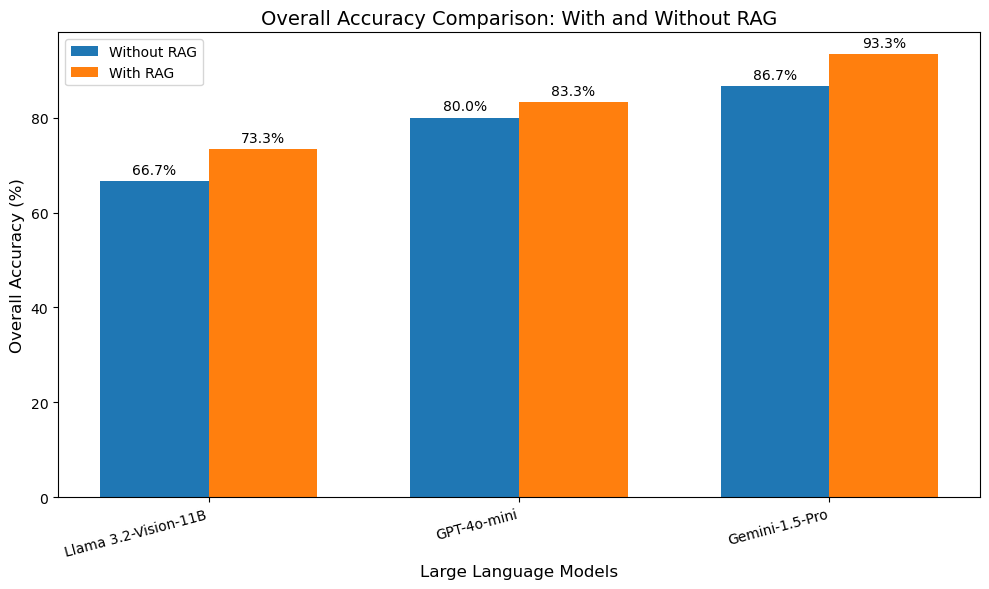

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Llama 3.2-Vision-11B', 'GPT-4o-mini', 'Gemini-1.5-Pro']
without_rag = [66.7, 80.0, 86.7]
with_rag = [73.3, 83.3, 93.3]

# X-axis positions
x = np.arange(len(models))
width = 0.35  # Width of the bars

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bars
bars1 = ax.bar(x - width/2, without_rag, width, label='Without RAG')
bars2 = ax.bar(x + width/2, with_rag, width, label='With RAG')

# Labels and title
ax.set_xlabel('Large Language Models', fontsize=12)
ax.set_ylabel('Overall Accuracy (%)', fontsize=12)
ax.set_title('Overall Accuracy Comparison: With and Without RAG', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend()

# Adding data labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset above the bar
                    textcoords="offset points",
                    ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()
